# Description

Here I will do cross-validation without choosing the best model on stage of predict TC-properties.

# Import and preparations

In [60]:
# import models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing
from loguru import logger
from collections import defaultdict

# Import cross-validation scheme
from sklearn.model_selection import LeaveOneOut

# Import metrics
from sklearn.metrics import mean_squared_error as mse

# Import GridSearch
from sklearn.model_selection import GridSearchCV

# Import data and preprocessing

In [46]:
data = pd.read_csv('data_tc.csv')

In [47]:
tc_properties = data[['VF FCC_A1#2', 'ND FCC_A1#2', 'MR FCC_A1#2', 
                      'VF HCP_A3#2', 'ND HCP_A3#2', 'MR HCP_A3#2',
                      'VF M7C3_D101', 'ND M7C3_D101', 'MR M7C3_D101']]

cons_and_temp_properties = data[['Fe', 'Cr', 'Ni', 'Mo',
                                   'Mn', 'C', 'Ti', 'Si', 'Nb', 'V', 'P', 'B', 'Al', 'N', 'S', 'Co', 'Cu',
                                   'W', 'As',  'HT stage 1 temperature',
                                   'HT stage 1 duration', 'HT stage 1 cooling', 'HT stage 2 temperature', 
                                    'HT stage 2 duration', 'HT stage 2 cooling']]
target = data['yeld strength']

## Classes

In [48]:
ModelClass = typing.Union[RandomForestRegressor, CatBoostRegressor, Lasso, SVR]
lo = LeaveOneOut()

## Params

In [77]:
RANDOM_FOREST_PARAMS = {
    'max_depth': [7, 9, 12, 15],
    'min_samples_leaf': [1, 2]
}

LASSO_PARAMS = {
    'lasso__alpha': list(np.linspace(0, 10, 100))
}

CAT_BOOST_PARAMS = {
    'max_depth': [1, 2, 3]
}

SVR_PARAMS = {
    'svr__C': [1, 10, 50, 100],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.5, 1]
}

# Required functions to cross-validation and plotting

In [50]:
def display_plot(x, y, rmse=0, title="", xlabel="", ylabel="", color="blue", grid=False):
    """Display plot"""
    
    line = np.linspace(min(x), max(x))
    plt.plot(x, y, 'o', color=color)
    plt.plot(line, line, color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if grid:
        plt.grid()
    
    

In [59]:
def display_tc_pred(tc_true, tc_pred, rmse=0, color="blue", grid=False):
    """Display predictions for TC"""
    
    for column in tc_pred.columns:
        prediction = tc_pred[column]
        true = tc_properties[column]
        
        line = np.linspace(min(true), max(true))
        plt.plot(true, prediction, 'o', color=color)
        plt.plot(line, line, color='red')
        plt.xlabel(f"True {column}", fontsize='17')
        plt.ylabel(f"Predict {column}", fontsize='17')
        plt.title(f"{column}", fontsize='17')
        
        if grid:
            plt.grid()
        plt.show()

In [83]:
def fit_tc_property(model: ModelClass, params: dict[str, list] ,
                                x_data: pd.DataFrame, tc_prop: str)-> tuple[ModelClass, float]:
    """Fit model TC propety.
    
        Args:
            model: ModelClass -- sklearn or CatBoost Model to predict
            params: dict[str, list] -- params to GridSearchCV
            x_data: pd.DataFrame -- DataFrame with features to be trained on
            tc_prop: str -- tc property to be predicted
        Returns:
            best_model: ModelClass -- best model after GridSearchCV
            score: float -- score based on cv
    """
    
    tc_prop_true_values: pd.DataFrame = tc_properties[tc_prop]
    
    logger.info(f"Fit model using GridSearchCV and choose best params for {tc_prop}")
    # Fit model
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error',
                        cv=lo.split(x_data), verbose=1)
    grid.fit(x_data, tc_prop_true_values)
    
    logger.info("Fitted successfully. Building best model and best scores")
    best_model = grid.best_estimator_
    score = grid.best_score_
    
    return best_model, score

In [52]:
def select_name_and_params(model: ModelClass) -> tuple[str, dict[str, list]]:
    """For model select name and params.
    
        Args:
            model: ModelClass -- model
        Returns:
            name, params
    
    """
    
    # Select params:
    if isinstance(model, RandomForestRegressor):
        params = RANDOM_FOREST_PARAMS
        name = 'RandomForest'
    elif isinstance(model, CatBoostRegressor):
        params = CAT_BOOST_PARAMS
        name = 'CatBoost'
    elif isinstance(model, Lasso):
        params = LASSO_PARAMS
        name = 'Lasso'
    elif isinstance(model, SVR):
        params = SVR_PARAMS
        name = 'SVR'
    else:
        raise ValueError("Unknown model type")
    
    return name, params

In [65]:
def find_best_models_and_score_tc(model: ModelClass, 
                                  x_data: pd.DataFrame) -> dict[str, typing.Union[str, list[ModelClass, float]]]:
    """Fits fixed models for each TC property
    
        Args:
            model: ModelClass -- fixed model to be fitted.
            x_data: pd.DataFrame -- DataFrame with features to be trained on
        Returns:
            comradship_model:  dict[str, 
                typing.Union[str, list[ModelClass, float]] --  Dictionary with name of tc property and name as a keys and 
                                                            list with best model, best cv score as value
    """
    name, params = select_name_and_params(model)
    comradship_model = {}
    comradship_model['name'] = name
    for tc_prop in tc_properties.columns:
        best_model, score = fit_tc_property(model=model, params=params, x_data=x_data, tc_prop=tc_prop)
        comradship_model[tc_prop] = [best_model, score]
    
    return comradship_model

In [85]:
def predict_for_comradship_model(comradship_model: dict[str, typing.Union[str, list[ModelClass, float]]]) -> pd.DataFrame:
    """Predict TC properties for comradship_model.
    
        Args:
            comradship_model:dict[str, typing.Union[str, list[ModelClass, float]]] -- comradship_model
        Returns:
            tc_pred: pd.DataFrame -- predictions for TC properties
    
    """
    preds = {}
    for key, value in comradship_model.items():
        if key == 'name':
            continue
        model = value[0]
        prop_pred = model.predict(cons_and_temp_properties)
        preds[key] = prop_pred
    
    tc_pred = pd.DataFrame(preds, columns=tc_properties.columns)
    return tc_pred

In [55]:
def find_best_model_for_predict_target(models: ModelClass, 
                                tc_pred: pd.DataFrame,
                                y: pd.Series) -> tuple[str, ModelClass, float]:
    
    """Finds best model to predict target based on TC properties
        
        Args:
            models: ModelClass -- models
            tc_pred: pd.DataFrame -- TC predictions
            y: pd.Series -- values of target
        Returns:
            best_model_name, best_model, best_score
    
    """
        
    _rating: dict[str, list[ModelClass, float]] = defaultdict()
    
    for model in models:
        
        logger.info(f"Start grid search to predict target for {name}")
        grid = GridSearchCV(estimator=model, params=params, cv=lo.split(tc_pred), 
                            scoring='neg_root_mean_squared_error', verbose=0)
        logger.info("Fitted successfully. Getting best model and cv score")
        grid.fit(tc_pred, y)
        best_model = grid.best_estimator_
        best_score = grid.best_score_
        
        logger.info("Collect info about model into rating")
        _rating[name] = [best_model, best_score]
    
    logger.info("Sort rating by cv score and return best model")
    rating = {k: v for k, v in sorted(_rating.items(), key=lambda item: item[1][1])}
    
    best_model_name = list(rating.keys())[0]
    best_score = list(rating.values())[0][1]
    best_model = list(rating.values())[0][0]
    
    return best_model_name, best_model, best_score
        
        

In [71]:
def process(ys_models: list[ModelClass], tc_models: list[ModelClass],
            x_data: pd.DataFrame, y: pd.Series):
    """Process
    
        Args:
            ys_models: list[ModelClass] -- models to predict target based on TC properties
            tc_models: list[ModelClass] -- models to predict TC properties based on consistance
            x_data: pd.DataFrame -- DataFrame with consistance
            y: pd.Series -- target
        
        Returns:
            list with models
            list with rating to every tc_model. 
            Example of output: [['RandomForest', 'RandomForest', -100.3], ['SVR', 'RandomForest', -130.3],
                                ['Lasso', 'Lasso', -1004.2], ['CatBoost', 'CatBoost', -90.3]]
                
    """
    
    logger.info("Start predicting TC properties based on consisitance")
    logger.info("Predicting TC properties for every TC model")
    
    rating = []
    models = []
    
    for tc_model in tc_models:
        logger.info(f"Predict TC props for {tc_model}")
        comradship_model = find_best_models_and_score_tc(model=tc_model, x_data=x_data)
        tc_model_name = comradship_model['name']
        tc_pred = predict_for_comradship_model(comradship_model=comradship_model)
        display_tc_pred(tc_properties, tc_pred)
        best_target_model_name, best_target_model, best_score = find_best_model_for_predict_target(ys_models, tc_pred, y)
        
        ratting = rating + [tc_model_name, best_target_model_name, best_score]
        models = models + [comradship_model, best_target_model]
    
    return models, rating

            

# Processing

## models

In [69]:
steps_SVR = [('scaler', StandardScaler()), ('svr', SVR())]
SVR_Pipeline = Pipeline(steps_SVR)

steps_Lasso = [('scaler', StandardScaler()), ('lasso', Lasso())]
Lasso_Pipeline = Pipeline(steps_Lasso)

ys_models = [CatBoostRegressor(verbose=0), RandomForestRegressor(), SVR_Pipeline, Lasso_Pipeline]
tc_models = [CatBoostRegressor(verbose=0), RandomForestRegressor(), SVR_Pipeline, Lasso_Pipeline]

## Process

2023-03-13 16:16:35.803 | INFO     | __main__:process:19 - Start predicting TC properties based on consisitance
2023-03-13 16:16:35.803 | INFO     | __main__:process:20 - Predicting TC properties for every TC model
2023-03-13 16:16:35.812 | INFO     | __main__:process:26 - Predict TC props for <catboost.core.CatBoostRegressor object at 0x000001E7D01A11E0>
2023-03-13 16:16:35.813 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for VF FCC_A1#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:18:14.367 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:18:14.384 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for ND FCC_A1#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:19:53.259 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:19:53.259 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for MR FCC_A1#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:21:32.047 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:21:32.047 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for VF HCP_A3#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:23:10.477 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:23:10.477 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for ND HCP_A3#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:24:49.825 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:24:49.842 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for MR HCP_A3#2


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:26:32.134 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:26:32.146 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for VF M7C3_D101


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:28:10.675 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:28:10.675 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for ND M7C3_D101


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:29:49.392 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores
2023-03-13 16:29:49.407 | INFO     | __main__:fit_tc_property:17 - Fit model using GridSearchCV and choose best params for MR M7C3_D101


Fitting 39 folds for each of 3 candidates, totalling 117 fits


2023-03-13 16:31:28.162 | INFO     | __main__:fit_tc_property:23 - Fitted successfully. Building best model and best scores


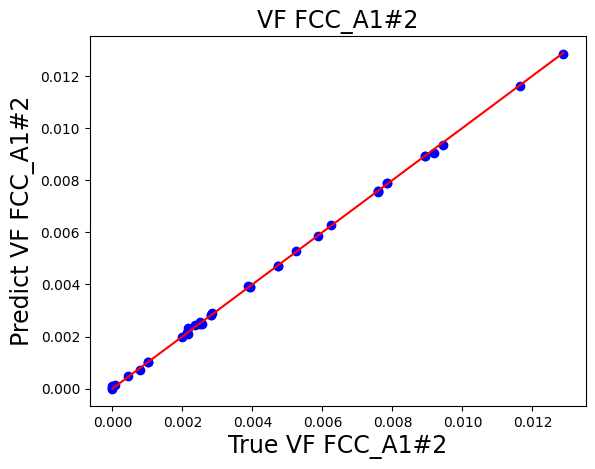

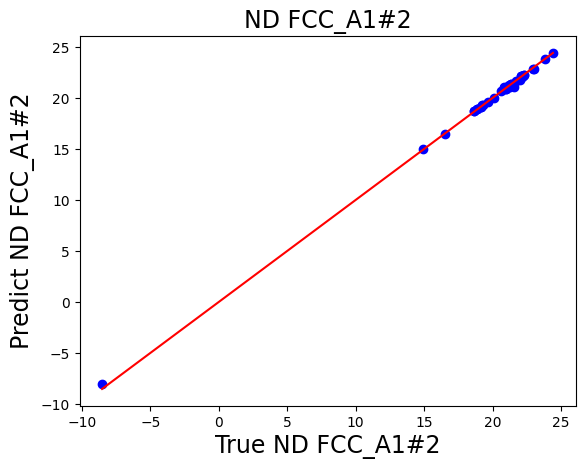

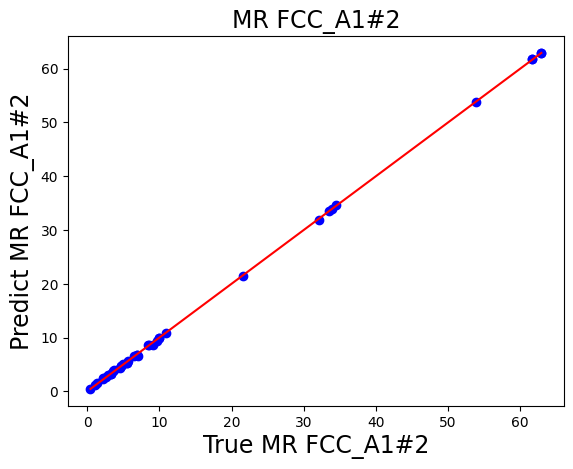

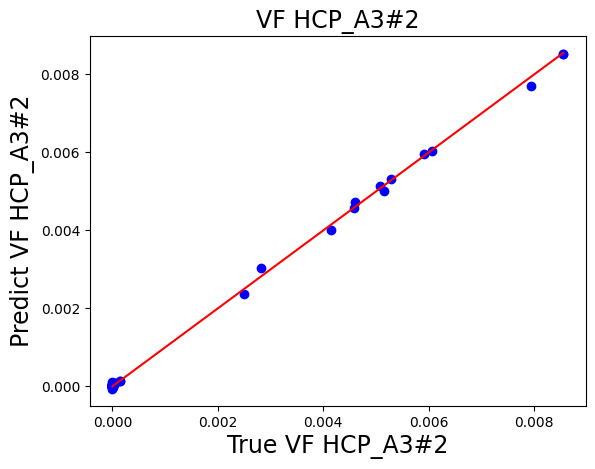

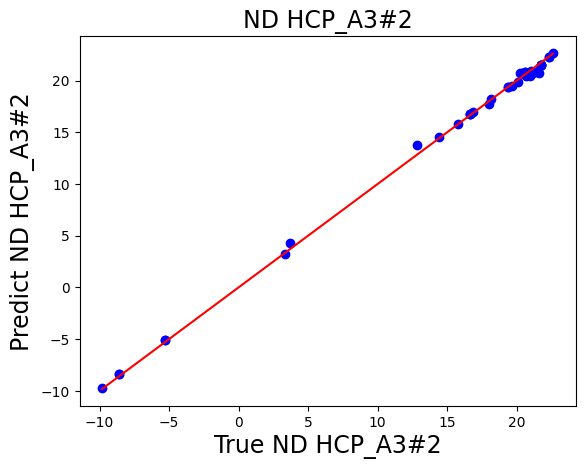

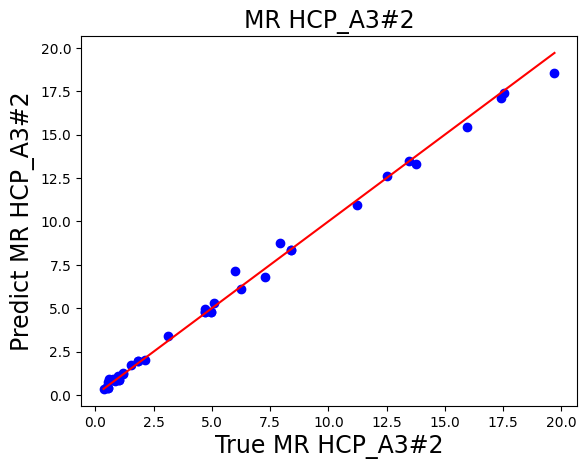

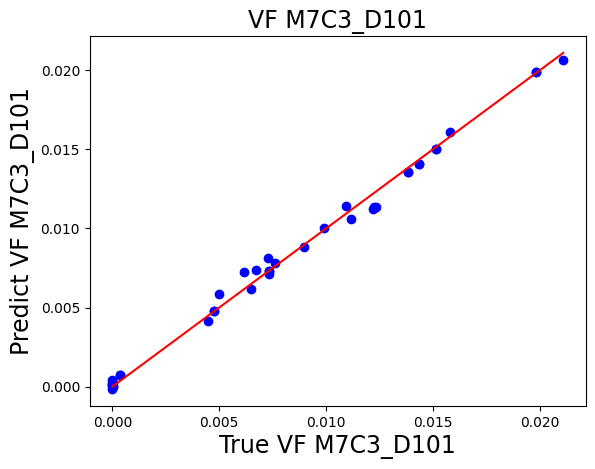

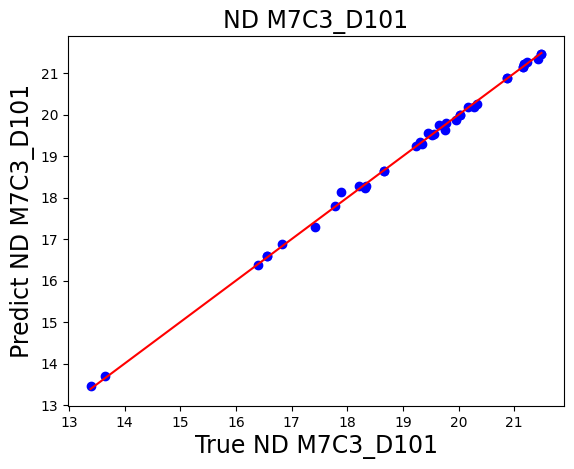

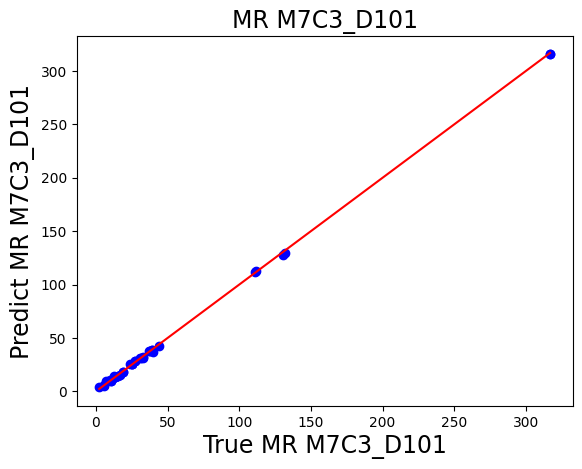

NameError: name 'name' is not defined

In [86]:
models, rating = process(ys_models=ys_models, tc_models=tc_models, x_data=cons_and_temp_properties, y=target)